In [1]:
from pyspark.ml.feature import Bucketizer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

sdf = spark.read.parquet("gs://my-bucket-an/cleaned/reviews1.parquet")


In [3]:
author_num_reviews_assembler = VectorAssembler(inputCols=['author_num_reviews'], outputCol='author_num_reviewsVector')
sdf = author_num_reviews_assembler.transform(sdf)

In [4]:
author_num_reviews_scaler = MinMaxScaler(inputCol="author_num_reviewsVector", outputCol="author_num_reviewsScaled")
sdf = author_num_reviews_scaler.fit(sdf).transform(sdf)
sdf.show()

+----------------+-----+--------------+-----------------+------------------+-----------------------+-------------------------+---------+----------------------------------+--------+--------+-----------+-------------------+-------------+------------------------+------------------------+
|recommendationid|appid|          game|   author_steamid|author_num_reviews|author_playtime_forever|author_playtime_at_review| language|                            review|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|author_num_reviewsVector|author_num_reviewsScaled|
+----------------+-----+--------------+-----------------+------------------+-----------------------+-------------------------+---------+----------------------------------+--------+--------+-----------+-------------------+-------------+------------------------+------------------------+
|       148919893|   10|Counter-Strike|76561199036724879|                 3|                  197.0|                      197|  russian|      

In [19]:


columns_a = [
    'author_num_reviews', 
    'author_playtime_forever', 
    'author_playtime_at_review',
    'comment_count',
    'votes_up',
    'votes_funny'
]
vector_assembler = VectorAssembler(inputCols=columns_a, outputCol='features')

min_max_scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

stages = [vector_assembler, min_max_scaler]

pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(sdf)
scaled_df = pipeline_model.transform(sdf)

scaled_df.show()


+----------------+-----+--------------+-----------------+------------------+-----------------------+-------------------------+---------+----------------------------------+--------+--------+-----------+-------------------+-------------+--------------------+--------------------+
|recommendationid|appid|          game|   author_steamid|author_num_reviews|author_playtime_forever|author_playtime_at_review| language|                            review|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|            features|     scaled_features|
+----------------+-----+--------------+-----------------+------------------+-----------------------+-------------------------+---------+----------------------------------+--------+--------+-----------+-------------------+-------------+--------------------+--------------------+
|       148919893|   10|Counter-Strike|76561199036724879|                 3|                  197.0|                      197|  russian|                          стар

In [9]:
scaled_df.select(['features', 'scaled_features']).show()

+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|[3.0,197.0,197.0,...|[1.91479176639540...|
|[21.0,441.0,441.0...|[0.00191479176639...|
|[1.0,1440.0,1313....|(6,[1,2],[2.46616...|
|[4.0,1636.0,1612....|[2.87218764959310...|
|[2.0,197.0,197.0,...|[9.57395883197702...|
|[2.0,1685.0,1649....|[9.57395883197702...|
|[39.0,11.0,11.0,0...|[0.00363810435615...|
|[2.0,45119.0,4511...|[9.57395883197702...|
|[4.0,1271.0,1202....|[2.87218764959310...|
|[60.0,721.0,721.0...|[0.00564863571086...|
|[1.0,12107.0,1210...|(6,[1,2],[0.00207...|
|[5.0,42519.0,4251...|[3.82958353279080...|
|[3.0,6543.0,6322....|[1.91479176639540...|
|[1.0,25944.0,2594...|(6,[1,2],[0.00444...|
|[2.0,7818.0,7704....|[9.57395883197702...|
|[1.0,317.0,278.0,...|(6,[1,2],[5.42899...|
|[1.0,89.0,77.0,0....|(6,[1,2],[1.52422...|
|[31.0,141.0,115.0...|[0.00287218764959...|
|[1.0,5684.0,5617....|(6,[1,2],[9.73451...|
|[1.0,1762.0,1674....|(6,[1,2],[


[Stage 11:>                                                         (0 + 1) / 1]



In [20]:
trainingData, testData = scaled_df.randomSplit([0.7, 0.3], seed=42)

linear_reg = LinearRegression(labelCol='weighted_vote_score')
evaluator = RegressionEvaluator(labelCol='weighted_vote_score', metricName='rmse')

stagess = [linear_reg]
regression_pipe = Pipeline(stages=stagess)
grid = ParamGridBuilder()
grid = grid.build()

cv = CrossValidator(estimator=regression_pipe, 
                    estimatorParamMaps=grid, 
                    evaluator=evaluator, 
                    numFolds=3)

all_models = cv.fit(trainingData)
bestModel = all_models.bestModel

test_results = bestModel.transform(testData)

test_results.select('author_num_reviews', 'author_playtime_forever', 'comment_count', 'votes_up', 'weighted_vote_score', 'prediction').show(truncate=False)



24/05/10 02:20:02 WARN Instrumentation: [30d574e5] regParam is zero, which might cause numerical instability and overfitting.
24/05/10 02:22:36 WARN Instrumentation: [5b4aacb3] regParam is zero, which might cause numerical instability and overfitting.
24/05/10 02:24:47 WARN Instrumentation: [ceab28f0] regParam is zero, which might cause numerical instability and overfitting.
24/05/10 02:25:55 WARN Instrumentation: [8caa1b85] regParam is zero, which might cause numerical instability and overfitting.


+------------------+-----------------------+-------------+--------+-------------------+-------------------+
|author_num_reviews|author_playtime_forever|comment_count|votes_up|weighted_vote_score|prediction         |
+------------------+-----------------------+-------------+--------+-------------------+-------------------+
|92                |76.0                   |0            |0       |0.0                |0.1780857652836652 |
|2                 |80062.0                |0            |0       |0.0                |0.17477248623043576|
|8                 |4056.0                 |0            |0       |0.0                |0.17227446004569358|
|3                 |31927.0                |0            |1       |0.528985500335693  |0.17335627060513528|
|1                 |25901.0                |0            |0       |0.0                |0.17225824553147026|
|8                 |1664.0                 |0            |2       |0.54356849193573   |0.1734062662875619 |
|2                 |11617.0 

In [21]:
bestModel.write().save("gs://my-bucket-an/models/model2")

In [11]:
rmse = evaluator.evaluate(test_results,
{evaluator.metricName:'rmse'})
r2 =evaluator.evaluate(test_results,{evaluator.metricName:'r2'})
print(f"RMSE: {rmse} R-squared:{r2}")

RMSE: 0.24839715312907776 R-squared:0.0212562111632415


In [16]:
sdf_en = scaled_df.filter(scaled_df['language'] == 'english')

In [17]:
scaled_df.columns

['recommendationid',
 'appid',
 'game',
 'author_steamid',
 'author_num_reviews',
 'author_playtime_forever',
 'author_playtime_at_review',
 'language',
 'review',
 'voted_up',
 'votes_up',
 'votes_funny',
 'weighted_vote_score',
 'comment_count',
 'author_num_reviewsVector',
 'author_num_reviewsScaled',
 'features',
 'scaled_features']

In [18]:
sdf_en.show()

+----------------+-----+--------------+-----------------+------------------+-----------------------+-------------------------+--------+--------------------+--------+--------+-----------+-------------------+-------------+------------------------+------------------------+--------------------+--------------------+
|recommendationid|appid|          game|   author_steamid|author_num_reviews|author_playtime_forever|author_playtime_at_review|language|              review|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|author_num_reviewsVector|author_num_reviewsScaled|            features|     scaled_features|
+----------------+-----+--------------+-----------------+------------------+-----------------------+-------------------------+--------+--------------------+--------+--------+-----------+-------------------+-------------+------------------------+------------------------+--------------------+--------------------+
|       148912575|   10|Counter-Strike|76561198363716821|    

In [19]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer

In [20]:
regexTokenizer = RegexTokenizer(inputCol="review", outputCol="words", pattern="\\w+", gaps=False)
words_sdf = regexTokenizer.transform(sdf_en)
words_sdf.select("review", "words").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
from pyspark.sql.functions import split, size
from pyspark.ml.feature import RegexTokenizer

# Assuming sdf_en is your Spark DataFrame containing English reviews and 'review' is the column containing the review text

# Define the RegexTokenizer
regexTokenizer = RegexTokenizer(inputCol="review", outputCol="words", pattern="\\w+", gaps=False)

# Tokenize the review text
words_sdf = regexTokenizer.transform(sdf_en)

# Count the number of words in each review
words_sdf_with_num_words = words_sdf.withColumn('num_words', size(split(words_sdf['review'], ' ')))

# Show the resulting DataFrame
words_sdf_with_num_words.select('review', 'num_words').show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
df = sdf.select('votes_up','author_playtime_forever').sample(False, 0.25).toPandas()


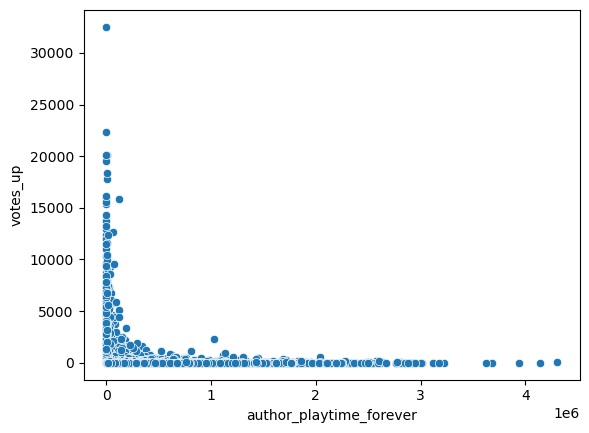

In [9]:
sns.scatterplot(x='author_playtime_forever', y='votes_up', data=df)
plt.show()

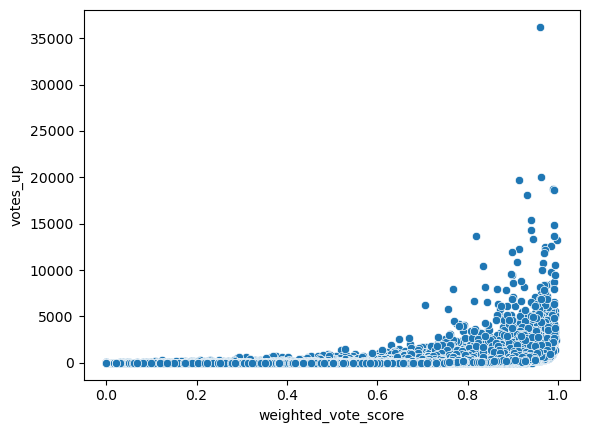

In [10]:
df2 = sdf.select('votes_up','weighted_vote_score').sample(False, 0.25).toPandas()
sns.scatterplot(x='weighted_vote_score', y='votes_up', data=df2)
plt.show()

AttributeError: 'FacetGrid' object has no attribute 'get_figure'

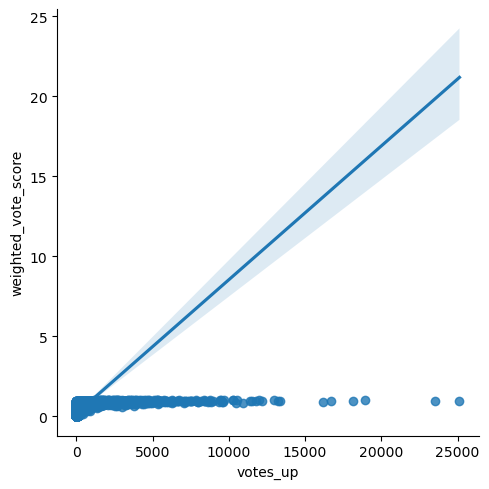

In [16]:
df2 = sdf.select('votes_up','weighted_vote_score').sample(False, 0.25).toPandas()
lp = sns.lmplot(x='votes_up', y='weighted_vote_score', data=df2)
figure = lp.get_figure()

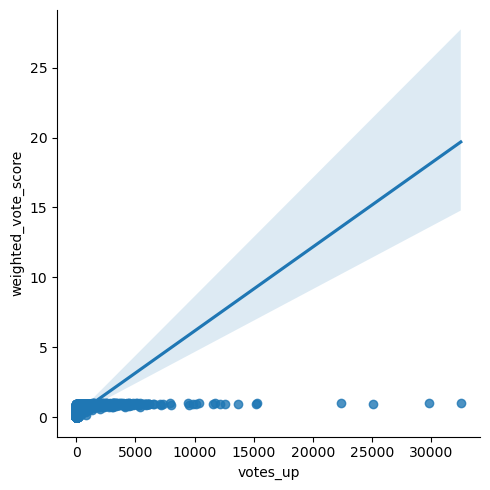

In [17]:
df2 = sdf.select('votes_up','weighted_vote_score').sample(False, 0.10).toPandas()
lp = sns.lmplot(x='votes_up', y='weighted_vote_score', data=df2)

In [23]:
test_results = bestModel.transform(testData)

In [ ]:
df3 = sdf.select('weighted_vote_score').sample(False, 0.25).toPandas()
sns.histplot(df3, bins=20, kde=True)